<a href="https://colab.research.google.com/github/sbowma15/text_analysis_and_script_generation/blob/main/text_analysis_and_script_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Number of observations:  44181
Number of fields in dataset:  1


/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:746: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 foe the car, and as
          it speeds away, the two men exchange one look.


          INT. THE CAR - AFTERNOON

          Charlie takes the wheel, and the two men approach the car,
          pushing against the steering column.


                          CHARLIE
          The driver will have to take over.
          They are now facing the rear of the car with a sign
          indicating the rear, which is lined with green tarps.


                          CHARLIE (CONT'D)
          The guy I want you to watch out
          for is...


     


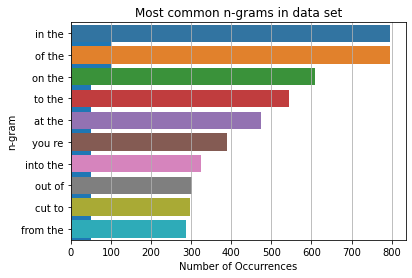

In [ ]:
#! python -m pip install transformers \
#   pandas matplotlib numpy \
#   nltk seaborn sklearn gensim pyldavis \
#   wordcloud textblob spacy textstat
import io
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from collections import Counter
from google.colab import files
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelWithLMHead
import random

#!python -m spacy download en_core_web_lg

#!pip install pandas --upgrade

#dataFrame= pd.read_csv(io.StringIO('../content/sample_data/filmText.csv'))
dataFrame= pd.read_csv(('../content/sample_data/filmText.csv'), nrows = 500000)

dataFrame.rename(columns={"A": "Start"})
#dataFrame.dropna(subset = ['Start'], inplace = True)


# Dataset summary statistics

print('Number of observations: ', len(dataFrame['Start']))
print('Number of fields in dataset: ', len(dataFrame.columns))

# Word frequency analysis
# Code from: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

# Our tokens are individual words; this counts words per observation

def plot_word_number_histogram(text):
    splitText = text.str.split(' ')
    splitText = splitText.map(lambda x: len(x))
    splitTextHistogram = splitText.hist(range = [0, 500])
    splitTextHistogram.set_title("Word Frequency")
    splitTextHistogram.set_xlabel("Number of words")
    splitTextHistogram.set_ylabel("Number of observations")

#only passing in the one column because when I made the .csv I couldnt get each
#word to directly go into its own cell. each block of text is in its own cell.
#this will be fine because we are going to split it all up anyways
plot_word_number_histogram(dataFrame['Start'])

# Analyze most common n-grams
# Code from: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

def plot_top_ngrams_barchart(text, n = 2):
    stop = set(stopwords.words('english'))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx])
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams = _get_top_ngram(text,n)[:10]
    x,y = map(list,zip(*top_n_bigrams))
    commonNGramsBarPlot = sns.barplot(x = y,y = x)
    commonNGramsBarPlot.set_title("Most common n-grams in data set")
    commonNGramsBarPlot.set_ylabel("n-gram")
    commonNGramsBarPlot.set_xlabel("Number of Occurrences")

plot_top_ngrams_barchart(dataFrame['Start'], 2)

tokenizer = AutoTokenizer.from_pretrained("cpierse/gpt2_film_scripts")
model = AutoModelWithLMHead.from_pretrained("cpierse/gpt2_film_scripts")
# making sure dropout is turned off
model.eval()
max_length = 250
num_samples = 3

output = model.generate(
            bos_token_id=random.randint(1,50000),
            do_sample=True,
            top_k=50,
            max_length = max_length,
            top_p=0.95,
            num_return_sequences=num_samples)

decoded_output = []
for sample in output:
        decoded_output.append(tokenizer.decode(
            sample, skip_special_tokens=True))
print(decoded_output[0])



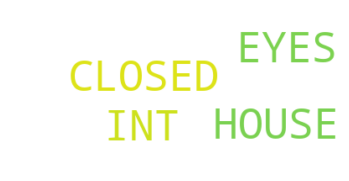

Positive label:  50.075 %
Negative label:  49.925 %
Total Number of Values:  667



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,Start
0,INT. HOUSE - CLOSED EYES
1,A young man's blue eyes slowly open. A girl m...
2,EXT. STREET CORNER - A LARGE TIRE
3,turns the corner and splashes through a puddle...
4,earlier rain. TUPAC SHAKUR blares from inside.


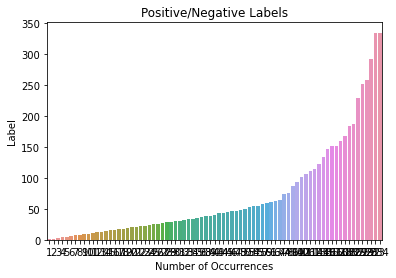

In [ ]:
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#Label/target summary statistics

#here we can see the more number of times the word is repeated the higher the
#the weight assigned to that word. I think this was sposed to be more binary
#but I used the Y value for both and x and why when creating the barplot, for
#reasons im still looking into, the graph wont generate when I use the x coords.
#the "Start" column values are the same for both x and y.... Not really sure here
# Check for and remove missing label values
targetLabelsData = dataFrame["Start"]

#?wordcloud

words = dataFrame.Start[0]
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(words)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


def plot_recommendations_histogram(text):
    #x = [dataFrame["Start"]]
    x = dataFrame["Start"].value_counts()
    #interesting this actually automativally drops n/a so we dont have to do
    #it earlier... which is good because dropna() wasnt working well
    #so says pandas documentation anyway
    y = text.value_counts()
    totalValuesNum = y[0] + y[1]

    print('Positive label: ', str(round((y[0] / totalValuesNum) * 100, 3)), '%')
    print('Negative label: ', str(round((y[1] / totalValuesNum) * 100, 3)), '%')
    print('Total Number of Values: ', totalValuesNum)
    #print('This is the y: ', y )
    print('')

    labelsBarPlot = sns.barplot(x, y)
    labelsBarPlot.set_title("Positive/Negative Labels")
    labelsBarPlot.set_xlabel("Number of Occurrences")
    labelsBarPlot.set_ylabel("Label")

plot_recommendations_histogram(targetLabelsData)

dataFrame.head()





In [ ]:


#This is my dsad attempt at finding the loss
def compute_loss(y_hat, y):
    return nn.BCELoss()(y_hat, y)
#Need to figure out y hat
#compute_loss(y,y)

In [ ]:
news['Start'].str.len().hist()


In [ ]:
from transformers import GPT2Tokenizer, GPT2ForTokenClassification
import torch
tokenizer = GPT2Tokenizer.from_pretrained('microsoft/DialogRPT-updown')
model = GPT2ForTokenClassification.from_pretrained('microsoft/DialogRPT-updown')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1] * inputs["input_ids"].size(1)).unsqueeze(0)  # Batch size 1

outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/812 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/DialogRPT-updown were not used when initializing GPT2ForTokenClassification: ['score.weight']
- This IS expected if you are initializing GPT2ForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at microsoft/DialogRPT-updown and are newly initialized: ['transformer.h.3.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.23.attn.masked_bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.21.attn.masked_bias', '

IndexError: ignored

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

#  initialization GPT2 Model Tokenizer class .
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
#  initialization GPT2 Model ,  Here to initialize GPT2LMHeadModel() Class GPT2 Model .
model = GPT2LMHeadModel.from_pretrained('gpt2')
# model.config.use_return_dict = None
# print(model.config.use_return_dict)

# GPT The context of the input for the first iteration of the model ,  Encode it to serialize .
#  meanwhile , generated It's also used to store GPT2 All iterations of the model produce token Indexes .
generated =
#  Convert the context content of the first iteration after serialization to pytorch Medium tensor form .
context = torch.tensor([generated])
#  The first iteration didn't have past_key_values Tuples .
past_key_values = None

for i in range(30):

    '''
     At this point, the model model Back to output by CausalLMOutputWithPastAndCrossAttentions class ,
     The model returns logits as well as past_key_values Object is one of the properties ,
    CausalLMOutputWithPastAndCrossAttentions(
            loss=loss,
            logits=lm_logits,
            past_key_values=transformer_outputs.past_key_values,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
            cross_attentions=transformer_outputs.cross_attentions,
        )
'''

    output = model(context, past_key_values=past_key_values)
    past_key_values = output.past_key_values
    #  At this time to get GPT2 The output of the model calculation hidden_states Of the last element of the second dimension in a tensor argmax value ,  It is concluded that the argmax The value is this time GPT2 Model iteration
    #  Compute the next generated token.  Be careful ,  Now if it's the first iteration ,  Output results hidden_states The shape of the tensor is (batch_size, sel_len, n_state);
    #  At this point, if it is the second iteration and the subsequent iteration ,  Output results hidden_states The shape of the tensor is (batch_size, 1, n_state), all_head_size=n_state=nx=768.
    token = torch.argmax(output.logits[..., -1, :])

    #  This iteration will generate token The tensor of becomes a two-dimensional tensor ,  For the next time GPT2 The context of model iterative computation context.
    context = token.unsqueeze(0)
    #  This iteration will generate token The sequence index of becomes a list generated
    generated += [token.tolist()]

#  take generated All of the token The index of token character .
sequence = tokenizer.decode(generated)
sequence = sequence.split(".")[:-1]
print(sequence)

ValueError: ignored

In [ ]:
class GPT2Model(model):
    def __init__(self, config):
        super().__init__(config)

        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.wpe = nn.Embedding(config.n_positions, config.n_embd)
        self.drop = nn.Dropout(config.embd_pdrop)
        self.h = nn.ModuleList([Block(config.n_ctx, config, scale=True) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)

        self.init_weights()

    def get_input_embeddings(self):
        return self.wte

    def set_input_embeddings(self, new_embeddings):
        self.wte = new_embeddings

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer}
        """
        for layer, heads in heads_to_prune.items():
            self.h[layer].attn.prune_heads(heads)

    #@add_start_docstrings_to_model_forward(GPT2_INPUTS_DOCSTRING)
    @add_code_sample_docstrings(
        tokenizer_class=_TOKENIZER_FOR_DOC,
        checkpoint="gpt2",
        output_type=BaseModelOutputWithPastAndCrossAttentions,
        config_class=_CONFIG_FOR_DOC,
    )
    def forward(
        self,
        input_ids=None,
        past_key_values=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # input_ids And inputs_embeds Only one... Can be entered , Yes input_ids Change just by changing input_ids Input the embedded layer to become similar to inputs_embeds Tensor ,
        #  Yes inputs_embeds You don't need to input_ids
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")

        #  Below is a list to make sure you type in input_ids、token_type_ids、position_ids The shape of the isotensor is the correct pattern :
        # <1>  If it's the first iteration of the model ,  Now input_ids、token_type_ids、position_ids The correct shape of the isotensor is  (batch_size, seq_len),
        # <2>  If it's the second and subsequent iteration of the model ,  Now input_ids、token_type_ids、position_ids The correct shape of the isotensor is  (batch_size, 1).
        #  Last ,  Will input input_ids、token_type_ids、position_ids The shape of an isotensor is saved to input_shape in .
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
            batch_size = input_ids.shape[0]
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
            batch_size = inputs_embeds.shape[0]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        if token_type_ids is not None:
            token_type_ids = token_type_ids.view(-1, input_shape[-1])
        if position_ids is not None:
            position_ids = position_ids.view(-1, input_shape[-1])

        if past_key_values is None:
            past_length = 0
            #  If this is GPT2 The first iteration of the model ,  Then there is no past_key_values list ( contain 12 individual present A list of ,
            #  That's in the code presents list ),  Now past_key_values The list contains 12 individual None List of values .
            past_key_values = [None] * len(self.h)
        else:
            past_length = past_key_values[0][0].size(-2)
        if position_ids is None:
            device = input_ids.device if input_ids is not None else inputs_embeds.device
            '''<1> GPT2Model For the first iteration, enter GPT2Model Of forward() Function past_key_values Parameter is None,  here past_length by 0,
              input_shape[-1] + past_length It's equal to the text code entered in the first iteration (input_ids) Of seq_len The dimension itself ,
               The position_ids The shape of the tensor is (batch_size, seq_len).
              <2>  if GPT2Mode In the second and subsequent iterations ,  here past_length For the last iteration of the record saved past_key_values in
               Tensor seq_len dimension ,  and input_shape[-1] + past_length It is equal to seq_len + 1,  Because in the second and subsequent iterations ,
               Input text encoding (input_ids) Of seq_len The dimension itself is 1, That is, in the second and subsequent iterations, only one word of text coding is input each time ,
               The position_ids The shape of the tensor is (batch_size, 1).'''
            position_ids = torch.arange(past_length, input_shape[-1] + past_length, dtype=torch.long, device=device)
            position_ids = position_ids.unsqueeze(0).view(-1, input_shape[-1])

        # Attention mask.
        # attention_mask Tensor is the attention mask tensor ,  It lets you fill in the special character [PAD] The attention score at is minimal , Its embedding Embedded values
        #  It's basically not captured in the multi attention aggregation operation .
        if attention_mask is not None:
            assert batch_size > 0, "batch_size has to be defined and > 0"
            attention_mask = attention_mask.view(batch_size, -1)
            # We create a 3D attention mask from a 2D tensor mask.
            # Sizes are [batch_size, 1, 1, to_seq_length]
            # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
            # this attention mask is more simple than the triangular masking of causal attention
            # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
            attention_mask = attention_mask[:, None, None, :]

            # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
            # masked positions, this operation will create a tensor which is 0.0 for
            # positions we want to attend and -10000.0 for masked positions.
            # Since we are adding it to the raw scores before the softmax, this is
            # effectively the same as removing these entirely.
            attention_mask = attention_mask.to(dtype=self.dtype)  # fp16 compatibility
            attention_mask = (1.0 - attention_mask) * -10000.0

        # If a 2D ou 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length],
        #  If there is a slave encoder encoder The encoder hidden state passed in from encoder_hidden_states,  The hidden state of the encoder is obtained encoder_hidden_states
        #  The shape of the (encoder_batch_size, encoder_sequence_length),  At the same time, define the encoder hidden state corresponding to attention_mask tensor ( namely encoder_attention_mask).
        if self.config.add_cross_attention and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # head_mask has shape n_layer x batch x n_heads x N x N
        # prune_heads() Can be combined with  https://github.com/huggingface/transformers/issues/850  understand .
        head_mask = self.get_head_mask(head_mask, self.config.n_layer)

        #  take input_ids、token_type_ids、position_ids The equivalent tensor input embedding layer self.wte()、 self.wpe() Then we get the embedded form tensor
        # inputs_embeds、position_embeds And token_type_embeds.
        if inputs_embeds is None:
            inputs_embeds = self.wte(input_ids)
        position_embeds = self.wpe(position_ids)
        hidden_states = inputs_embeds + position_embeds

        if token_type_ids is not None:
            token_type_embeds = self.wte(token_type_ids)
            hidden_states = hidden_states + token_type_embeds


NameError: ignored